### Assignment 2 Understanding transfer learning and fine tuning 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision import datasets
import os 
import numpy as np 
from typing import Literal
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from pprint import pprint
import seaborn as sns
import pandas as pd
print(f"[INFO] Torch infos: {torch.__version__}")


[INFO] Torch infos: 2.6.0+cu124


# We need transform from resnet18 and its weights


In [2]:
transform = ResNet18_Weights.DEFAULT.transforms()

# pick a dataset  you can import from

```python
from torchvision import datasets
```

# Easy picks:

- Food101
- Flowers102
- DTD
- FGVAircraft

# Other picks:

```python

full_train = datasets.OxfordIIITPet(root="data", split="trainval", download=True, transform=transform)
test_ds    = datasets.OxfordIIITPet(root="data", split="test", download=True, transform=transform)

```


In [3]:
full_train = datasets.FGVCAircraft('../Dataset', split="trainval", transform=transform, download=True)
test_ds = datasets.FGVCAircraft('../Dataset', split="test", download=True, transform=transform)

className = full_train.classes

print(f"Number of Classes: {len(className)}")

Number of Classes: 100


# Split the data

In [4]:
train_ratio = 0.8
train_size = int(len(full_train) * train_ratio)

validation_size = len(full_train) - train_size

train_ds, validation_ds = random_split(full_train, [train_size, validation_size])

print("Train Size:", train_size)
print("Validation Size:", validation_size)
print("Train and Validation Ds", train_ds, validation_ds)

Train Size: 5333
Validation Size: 1334
Train and Validation Ds <torch.utils.data.dataset.Subset object at 0x0000028A03AA3890> <torch.utils.data.dataset.Subset object at 0x0000028A03AA3850>


# load the train, validation and test split 

In [5]:

print(f"Training set size: {len(train_ds)} samples")
print(f"Validation set size: {len(validation_ds)} samples")
print(f"Test set size: {len(test_ds)} samples")

assert len(train_ds) + len(validation_ds) == len(full_train)

Training set size: 5333 samples
Validation set size: 1334 samples
Test set size: 3333 samples


# create dataloader handler from the dataset

In [6]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
validation_loader = DataLoader(validation_ds, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)

# now create the cnn, use the resnet18 as backbone, and ResNet18_Weights as initial weights.
- create the backbone
- create a classifier 
- based on your dataset add the correct number of output classes
- the classifier have to be trainable.

# Question 1?
- Why we freeze the backbone? Why not the classifier?

We freeze the backbone as it has already been trained on a large dataset and it knows the pattern of edges, shapes or textures of those images. However the classifier hasn't been seen anything in the dataset. When we initialize the classifier randomly, it produces gradients that might destroy the pre trained weights of the backbone during the backward process through the network. Therefore, by freezing the backbone we don't mess with the perfect state of the backbone. However if we freeze the classifier, it will just produce random guesses which we don't want in this case.

# add the train evaluation, and predict functions here

In [7]:
class Resnet18TransferLearning(nn.Module):
    def __init__(self, number_of_output_classes: int, weights=ResNet18_Weights.DEFAULT, freeze_backbone: bool = True, dense_units: list[int] = [256], dropout_probabilities: float = 0.3):
        super().__init__()

        self.weights = weights 

        backbone = resnet18(weights=weights)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        self.backbone_out = backbone.fc.in_features

        if freeze_backbone:
            for p in self.features.parameters():
                p.requires_grad = False
        
        mlp = []
        cur = self.backbone_out
        for h in dense_units:
            mlp += [
                nn.Linear(cur, h),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_probabilities),
            ]

            cur = h

        self.classifier = nn.Sequential(*mlp)

        self.final_classifier = nn.Linear(cur, number_of_output_classes)

        for p in self.classifier.parameters():
            p.requires_grad = True
        
        for p in self.final_classifier.parameters():
            p.requires_grad = True
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return self.final_classifier(x)

    def get_transform(self):
        return self.weights.transforms()


### Phase 1: Transfer learning

# freeze all layers except the classifier.
- train and evaluate the model for 50 epochs 
- remember to save val loss and train loss

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[DEVICE] Device loaded: {device}")

cnn_configuration = {
    "number_of_output_classes": 100,
    "freeze_backbone": True,
    "dense_units": [256],
    "dropout_probabilities": 0.3
}

model = Resnet18TransferLearning(**cnn_configuration).to(device)
pprint(model)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
loss_function = nn.CrossEntropyLoss()

[DEVICE] Device loaded: cuda
Resnet18TransferLearning(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momen

In [9]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    return running_loss/total, correct/total

In [10]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()  # Turn off Dropout / BatchNorm
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Track stats
        running_loss += loss.item() * images.size(0)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
    return running_loss / total, correct / total

In [11]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

epochs = 50
best_validation_accuracy = 0.0

print(f"[INFO] Starting Phase 1 Training for {epochs} epochs on device: {device}...")

for epoch in range(1, epochs + 1):

    train_loss, train_acc = train_one_epoch(
        model=model, 
        loader=train_loader, 
        criterion=loss_function, 
        optimizer=optimizer, 
        device=device
    )
    
    val_loss, val_acc = evaluate(
        model=model, 
        loader=validation_loader, 
        criterion=loss_function, 
        device=device
    )
    
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    training_accuracy.append(train_acc)
    validation_accuracy.append(val_acc)
    
    print(f"[EPOCH {epoch}/{epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}")

    
    if val_acc > best_validation_accuracy:
        best_validation_accuracy = val_acc
        torch.save(model.state_dict(), "cnn_aircraft_transfer_learning.pt")
        

print("\nTRAINING COMPLETE!!!")
print(f"BEST VALIDATION ACCURACY: {best_validation_accuracy:.2%}")

[INFO] Starting Phase 1 Training for 50 epochs on device: cuda...
[EPOCH 1/50] Train Loss: 4.5421, Train Acc: 2.83% | Val Loss: 4.3699, Val Acc: 7.12%
[EPOCH 2/50] Train Loss: 4.1160, Train Acc: 8.87% | Val Loss: 3.9217, Val Acc: 12.59%
[EPOCH 3/50] Train Loss: 3.6718, Train Acc: 14.34% | Val Loss: 3.5588, Val Acc: 19.04%
[EPOCH 4/50] Train Loss: 3.3291, Train Acc: 20.29% | Val Loss: 3.3302, Val Acc: 19.79%
[EPOCH 5/50] Train Loss: 3.0827, Train Acc: 24.08% | Val Loss: 3.1541, Val Acc: 23.76%
[EPOCH 6/50] Train Loss: 2.9017, Train Acc: 27.38% | Val Loss: 3.0475, Val Acc: 25.86%
[EPOCH 7/50] Train Loss: 2.7403, Train Acc: 31.45% | Val Loss: 2.9393, Val Acc: 28.79%
[EPOCH 8/50] Train Loss: 2.6279, Train Acc: 33.10% | Val Loss: 2.8889, Val Acc: 28.56%
[EPOCH 9/50] Train Loss: 2.5148, Train Acc: 35.06% | Val Loss: 2.8236, Val Acc: 29.39%
[EPOCH 10/50] Train Loss: 2.3879, Train Acc: 38.46% | Val Loss: 2.7536, Val Acc: 31.11%
[EPOCH 11/50] Train Loss: 2.3286, Train Acc: 39.79% | Val Loss: 2.

# Plot accuracy and loss

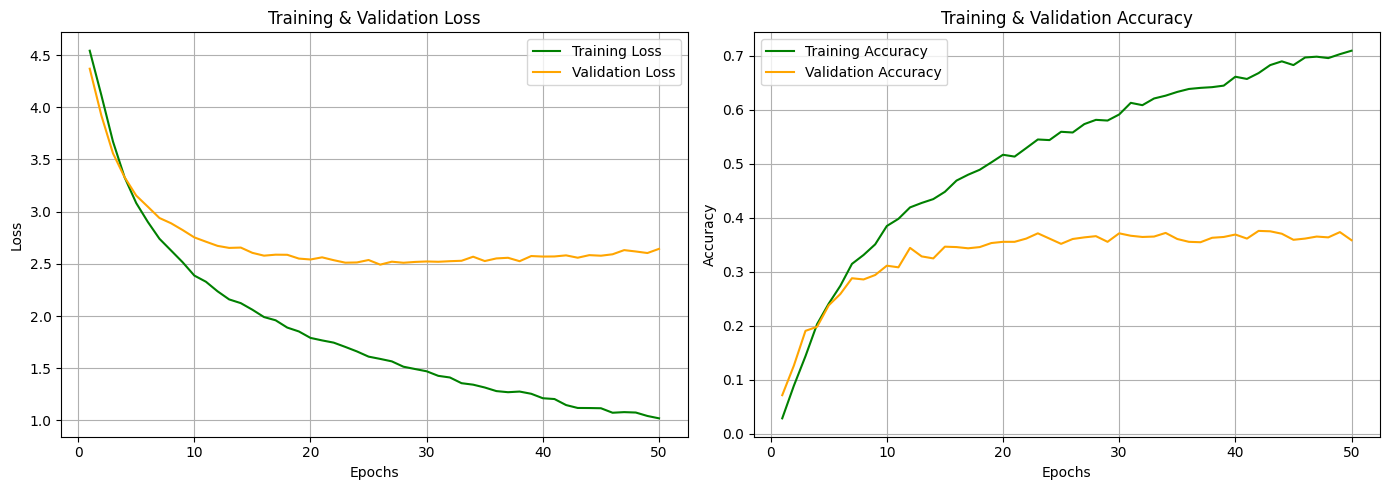

In [12]:
epochs_range = range(1, len(training_loss) + 1)

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_loss, label='Training Loss', color='green')
plt.plot(epochs_range, validation_loss, label='Validation Loss', color='orange')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy', color='green')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# plot predictions 

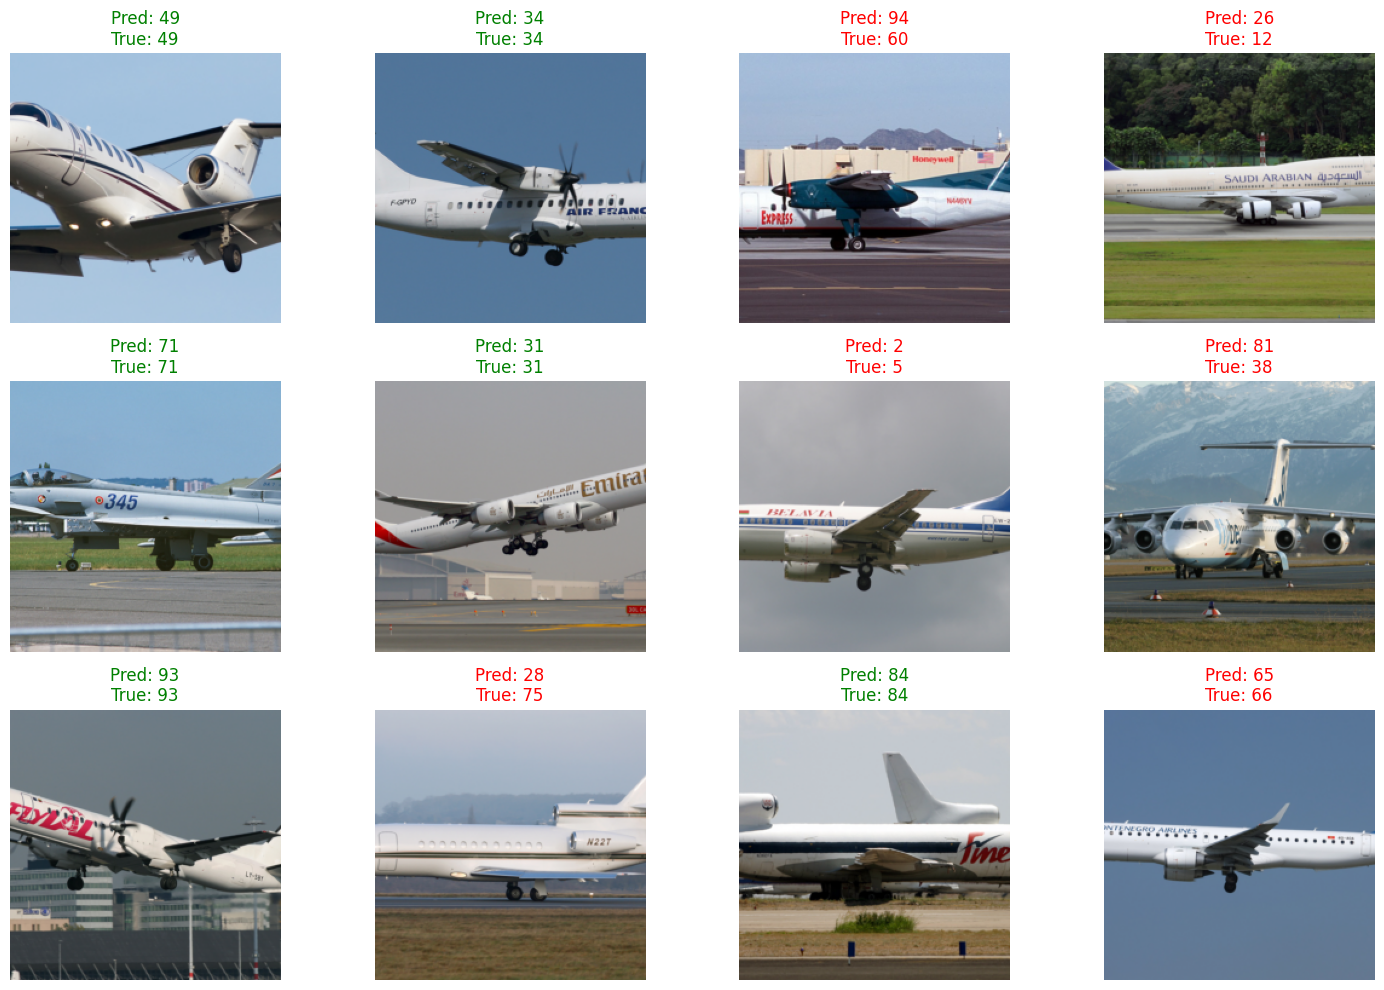

In [13]:
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

model.eval()

dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)


fig = plt.figure(figsize=(15, 10))
num_images_to_show = 12

for idx in range(num_images_to_show):
    ax = fig.add_subplot(3, 4, idx + 1, xticks=[], yticks=[])

    imshow(images[idx])

    pred_label = preds[idx].item()
    truth_label = labels[idx].item()
    
    color = 'green' if pred_label == truth_label else 'red'

    ax.set_title(f"Pred: {pred_label}\nTrue: {truth_label}", color=color)

plt.tight_layout()
plt.show()

# calculate TEST accuracy score 

In [14]:
test_loss, test_acc = evaluate(
    model=model, 
    loader=test_loader, 
    criterion=loss_function, 
    device=device
)

print(f"FINAL TEST ACCURACY: {test_acc * 100:.2%} | FINAL TEST LOSS: {test_loss:.4f}")



FINAL TEST ACCURACY: 3648.36% | FINAL TEST LOSS: 2.5823


# Calculate confusion matrices precision and recall 

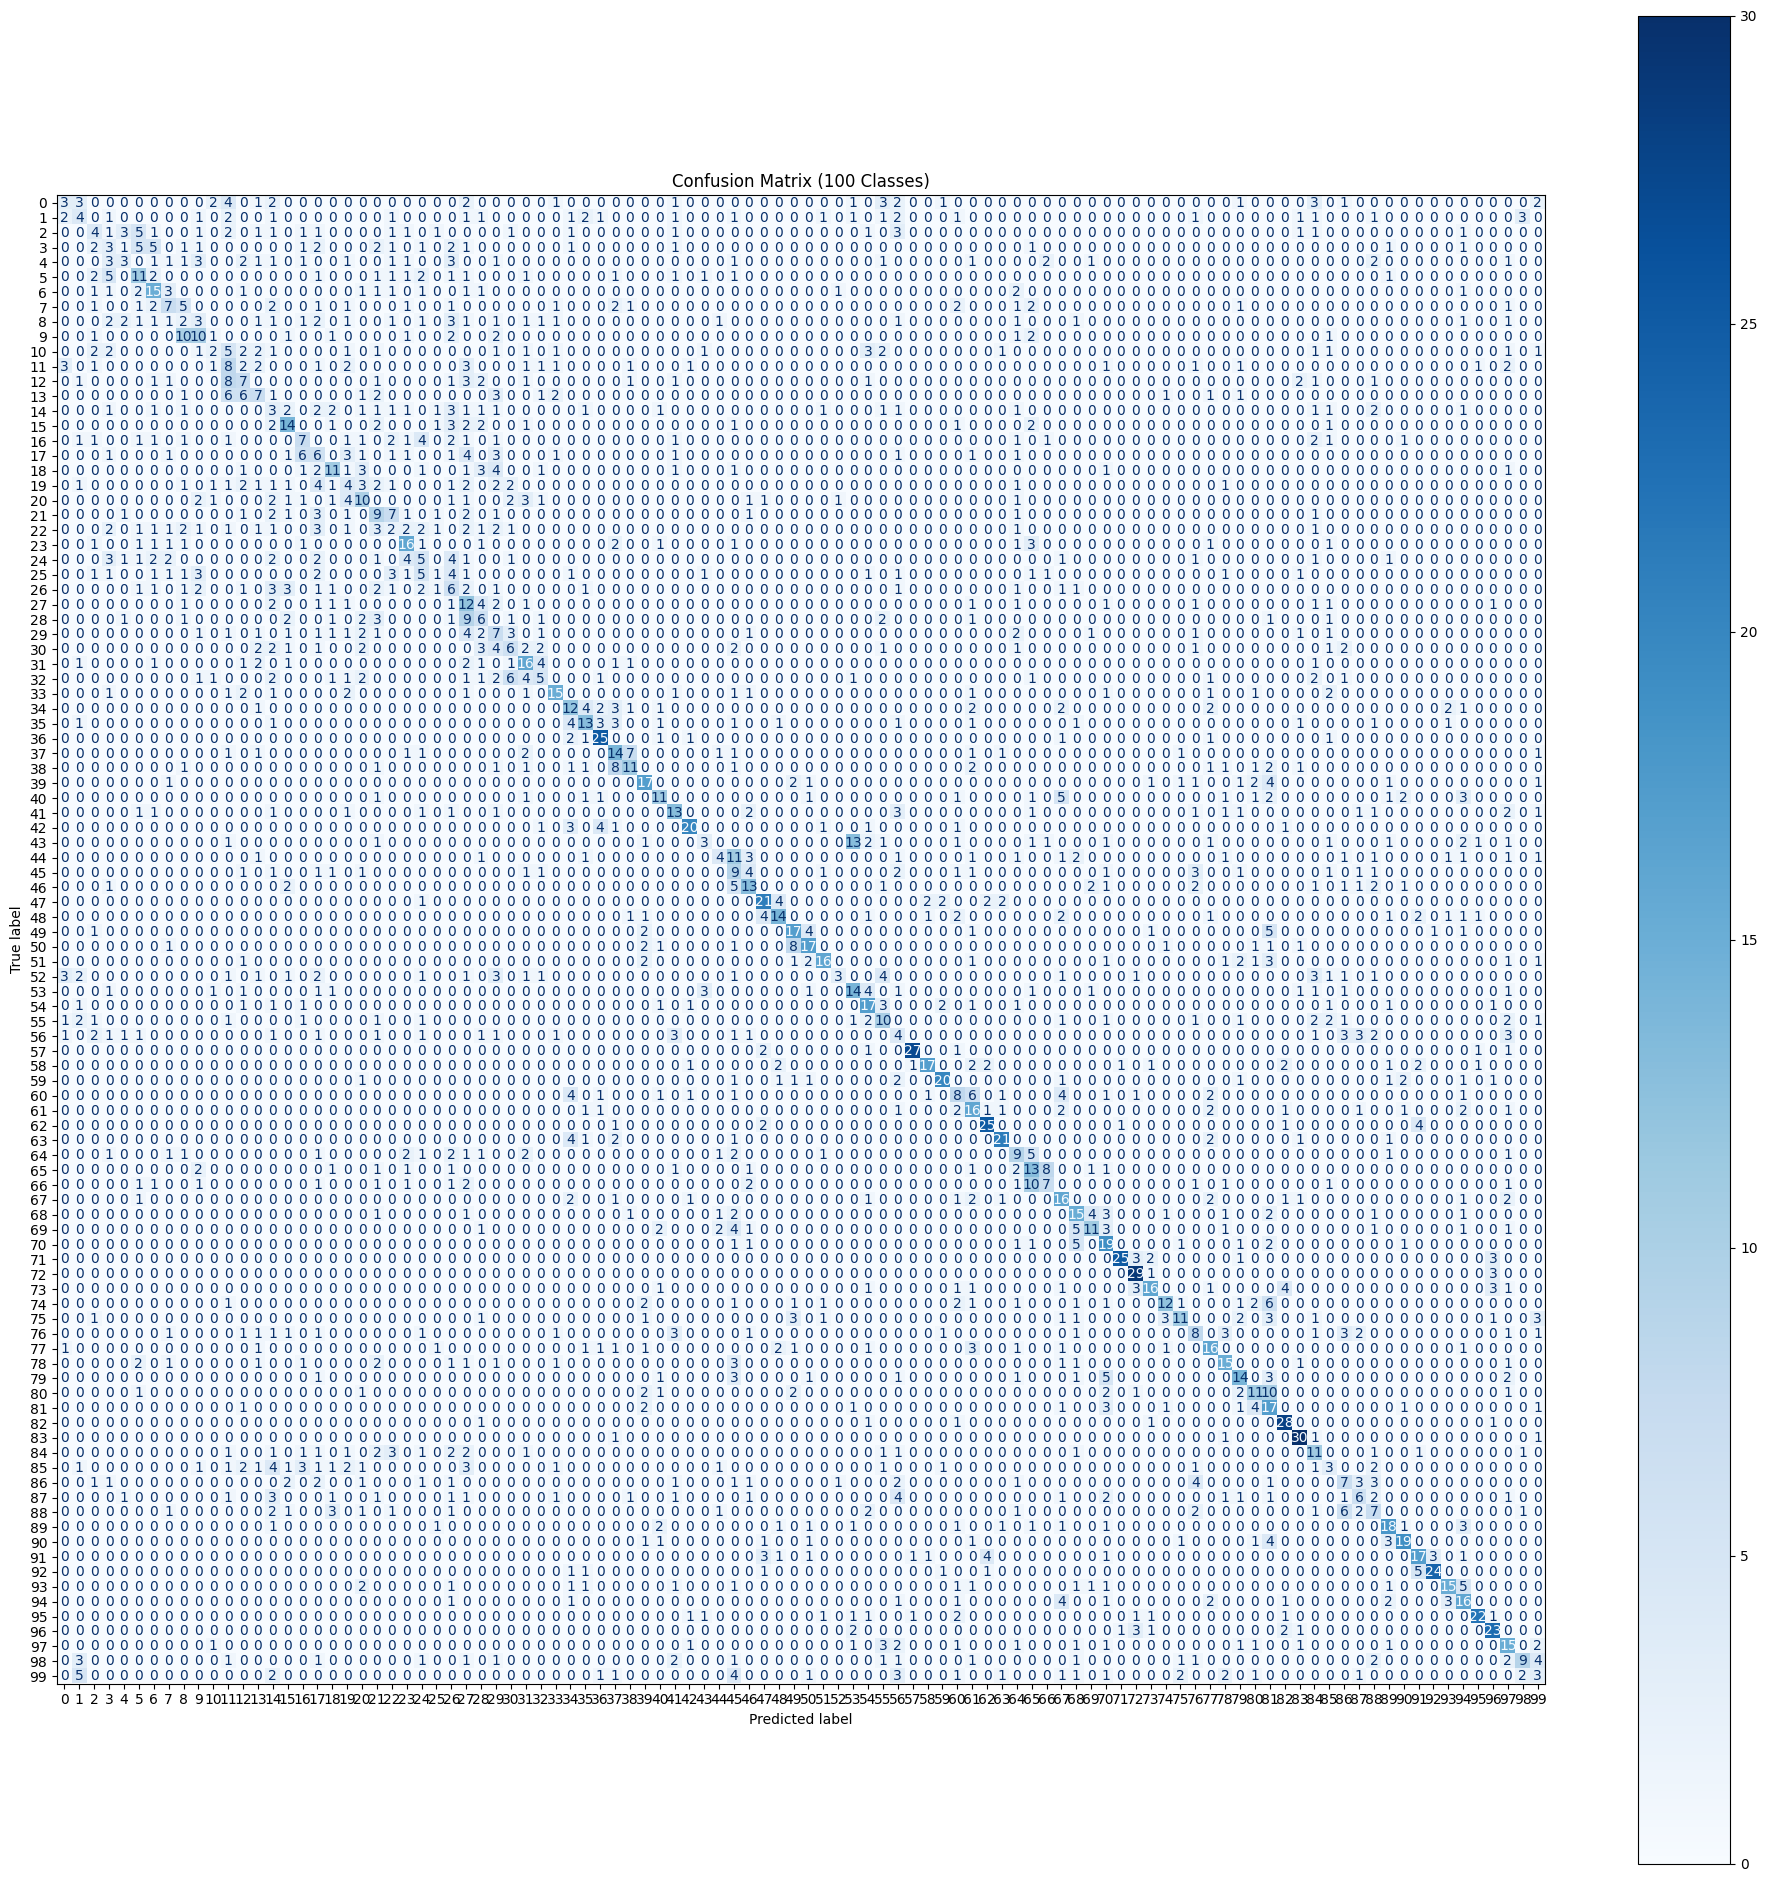

In [15]:
# 1. Gather all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Move to CPU and convert to list
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Generate and Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(24, 24))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d', ax=ax)
plt.title('Confusion Matrix (100 Classes)')
plt.show()

### Phase 2: Freeze layer 4 - Fine tuning

# from the freezed cnn unfreeze the  ``` layer4 ```. 

# Train for 50 epochs 

In [16]:
# Load the best weights from Phase 1 so we start from the peak performance

model.load_state_dict(torch.load("cnn_aircraft_transfer_learning.pt"))
print("[INFO] Successfully loaded best weights from Phase 1.")

for param in model.features[7].parameters():
    param.requires_grad = True

# Verify: Print roughly how many parameters are now trainable
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO] Total trainable parameters: {trainable_params:,}")

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)

ft_train_losses = []
ft_val_losses = []
ft_train_acc = []
ft_val_acc = []

epochs = 50
best_ft_accuracy = 0.0

print(f"\n[INFO] Starting Phase 2 (Fine-Tuning) for {epochs} epochs...")

for epoch in range(1, epochs + 1):
    # A. Train Step
    train_loss, train_acc = train_one_epoch(
        model=model, 
        loader=train_loader, 
        criterion=loss_function, 
        optimizer=optimizer, 
        device=device
    )
    
    # B. Evaluation Step
    val_loss, val_acc = evaluate(
        model=model, 
        loader=validation_loader, 
        criterion=loss_function, 
        device=device
    )
    
    # C. Store Results
    ft_train_losses.append(train_loss)
    ft_val_losses.append(val_loss)
    ft_train_acc.append(train_acc)
    ft_val_acc.append(val_acc)
    
    # D. Print Progress
    print(f"[EPOCH {epoch}/{epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}")

    # E. Save Best Model (New Filename for Phase 2)
    if val_acc > best_ft_accuracy:
        best_ft_accuracy = val_acc
        torch.save(model.state_dict(), "cnn_aircraft_fine_tuning.pt")
        print(f"  --> [SAVED] New best Phase 2 model saved with accuracy: {val_acc:.2%}")

print("\nPHASE 2 COMPLETE!!!")
print(f"BEST FINE-TUNED ACCURACY: {best_ft_accuracy:.2%}")

[INFO] Successfully loaded best weights from Phase 1.
[INFO] Total trainable parameters: 8,550,756

[INFO] Starting Phase 2 (Fine-Tuning) for 50 epochs...
[EPOCH 1/50] Train Loss: 1.1255, Train Acc: 67.41% | Val Loss: 2.2318, Val Acc: 41.23%
  --> [SAVED] New best Phase 2 model saved with accuracy: 41.23%
[EPOCH 2/50] Train Loss: 0.5737, Train Acc: 84.68% | Val Loss: 2.1646, Val Acc: 43.78%
  --> [SAVED] New best Phase 2 model saved with accuracy: 43.78%
[EPOCH 3/50] Train Loss: 0.3500, Train Acc: 92.20% | Val Loss: 2.1411, Val Acc: 44.45%
  --> [SAVED] New best Phase 2 model saved with accuracy: 44.45%
[EPOCH 4/50] Train Loss: 0.2462, Train Acc: 95.11% | Val Loss: 2.1182, Val Acc: 46.33%
  --> [SAVED] New best Phase 2 model saved with accuracy: 46.33%
[EPOCH 5/50] Train Loss: 0.1802, Train Acc: 97.07% | Val Loss: 2.1320, Val Acc: 46.18%
[EPOCH 6/50] Train Loss: 0.1423, Train Acc: 97.58% | Val Loss: 2.1346, Val Acc: 47.00%
  --> [SAVED] New best Phase 2 model saved with accuracy: 47.00

# Plot curves

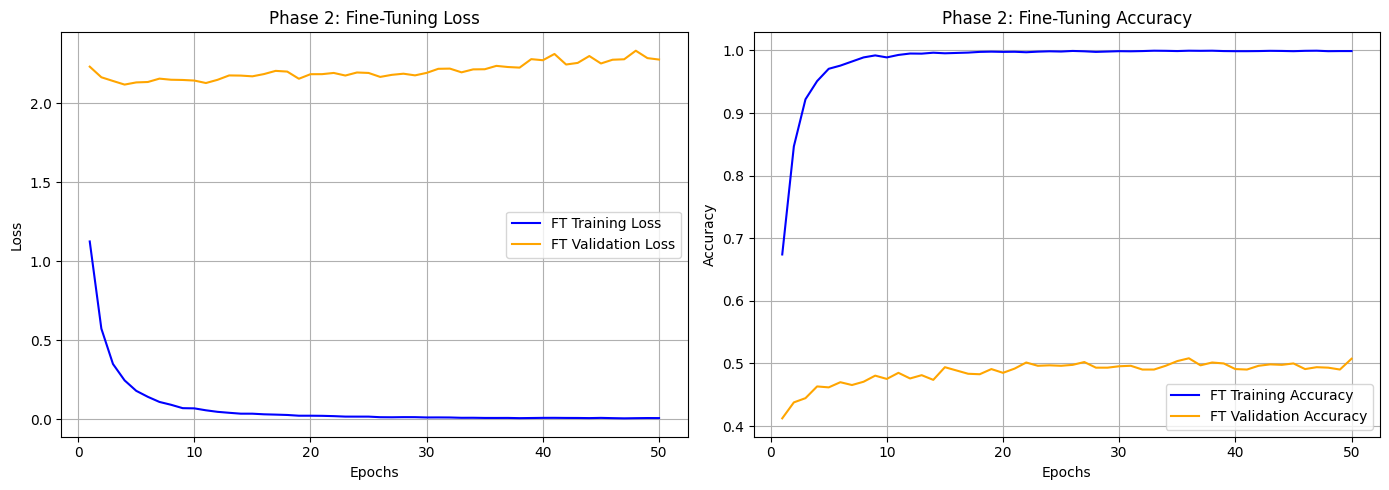

In [17]:
epochs_range = range(1, len(ft_train_losses) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, ft_train_losses, label='FT Training Loss', color='blue')
plt.plot(epochs_range, ft_val_losses, label='FT Validation Loss', color='orange')
plt.title('Phase 2: Fine-Tuning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, ft_train_acc, label='FT Training Accuracy', color='blue')
plt.plot(epochs_range, ft_val_acc, label='FT Validation Accuracy', color='orange')
plt.title('Phase 2: Fine-Tuning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# visualize prediction

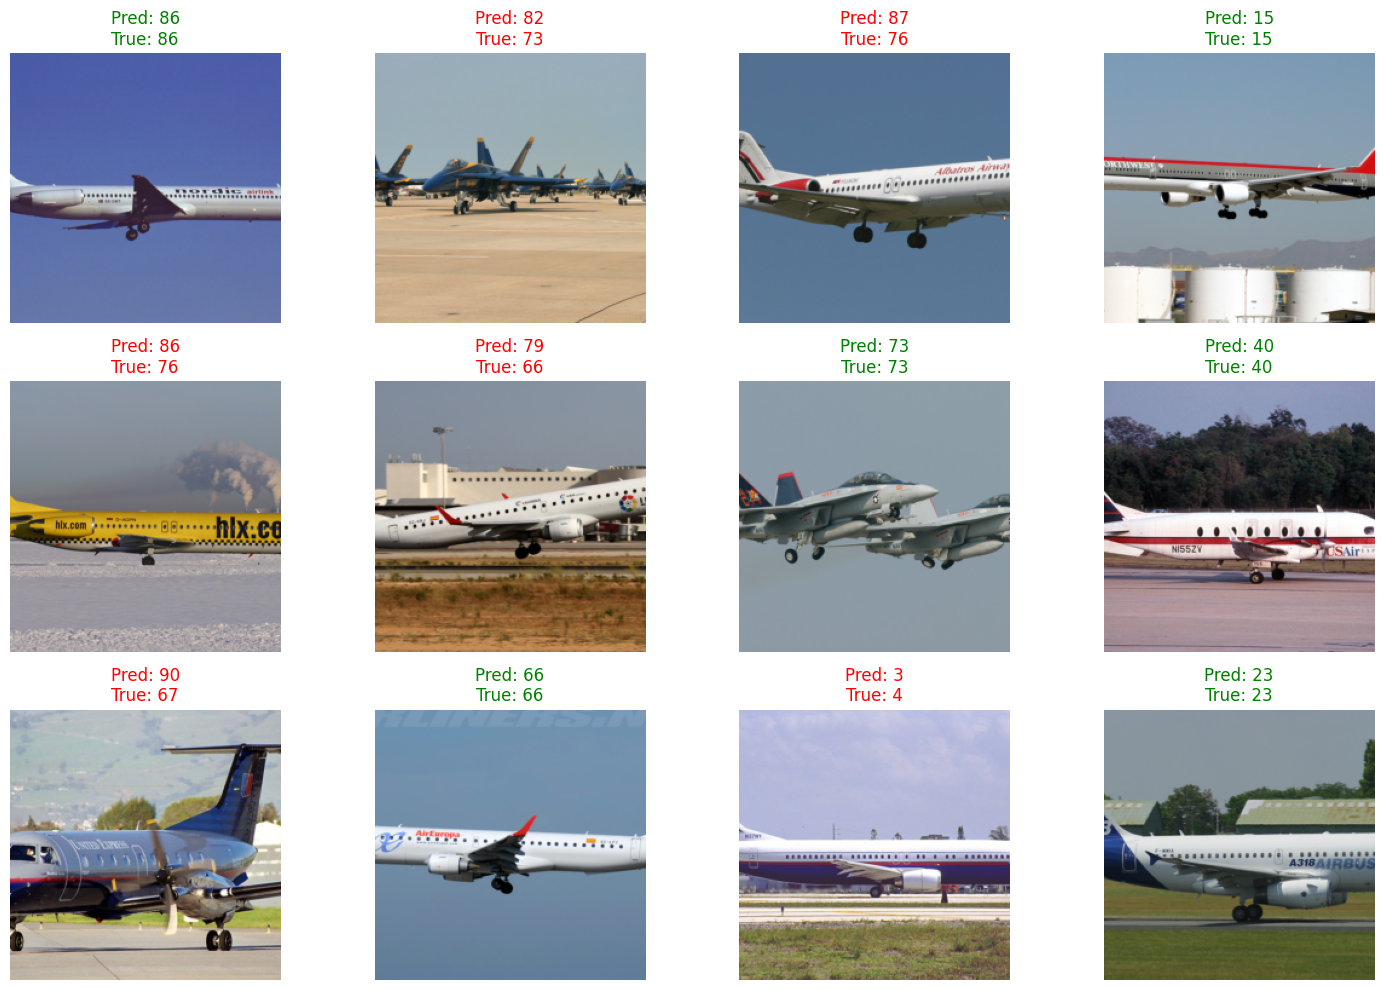

In [18]:
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

model.eval()

dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)


fig = plt.figure(figsize=(15, 10))
num_images_to_show = 12

for idx in range(num_images_to_show):
    ax = fig.add_subplot(3, 4, idx + 1, xticks=[], yticks=[])

    imshow(images[idx])

    pred_label = preds[idx].item()
    truth_label = labels[idx].item()
    
    color = 'green' if pred_label == truth_label else 'red'

    ax.set_title(f"Pred: {pred_label}\nTrue: {truth_label}", color=color)

plt.tight_layout()
plt.show()

# Calculate test accuracy score 

In [19]:
test_loss, test_acc = evaluate(
    model=model, 
    loader=test_loader, 
    criterion=loss_function, 
    device=device
)


print(f"PHASE 2 (FINE-TUNED) TEST ACCURACY: {test_acc :.2%} | PHASE 2 (FINE-TUNED) TEST LOSS: {test_loss:.4f}")


PHASE 2 (FINE-TUNED) TEST ACCURACY: 52.42% | PHASE 2 (FINE-TUNED) TEST LOSS: 2.2872


# calculate confusion matrix precision and recall

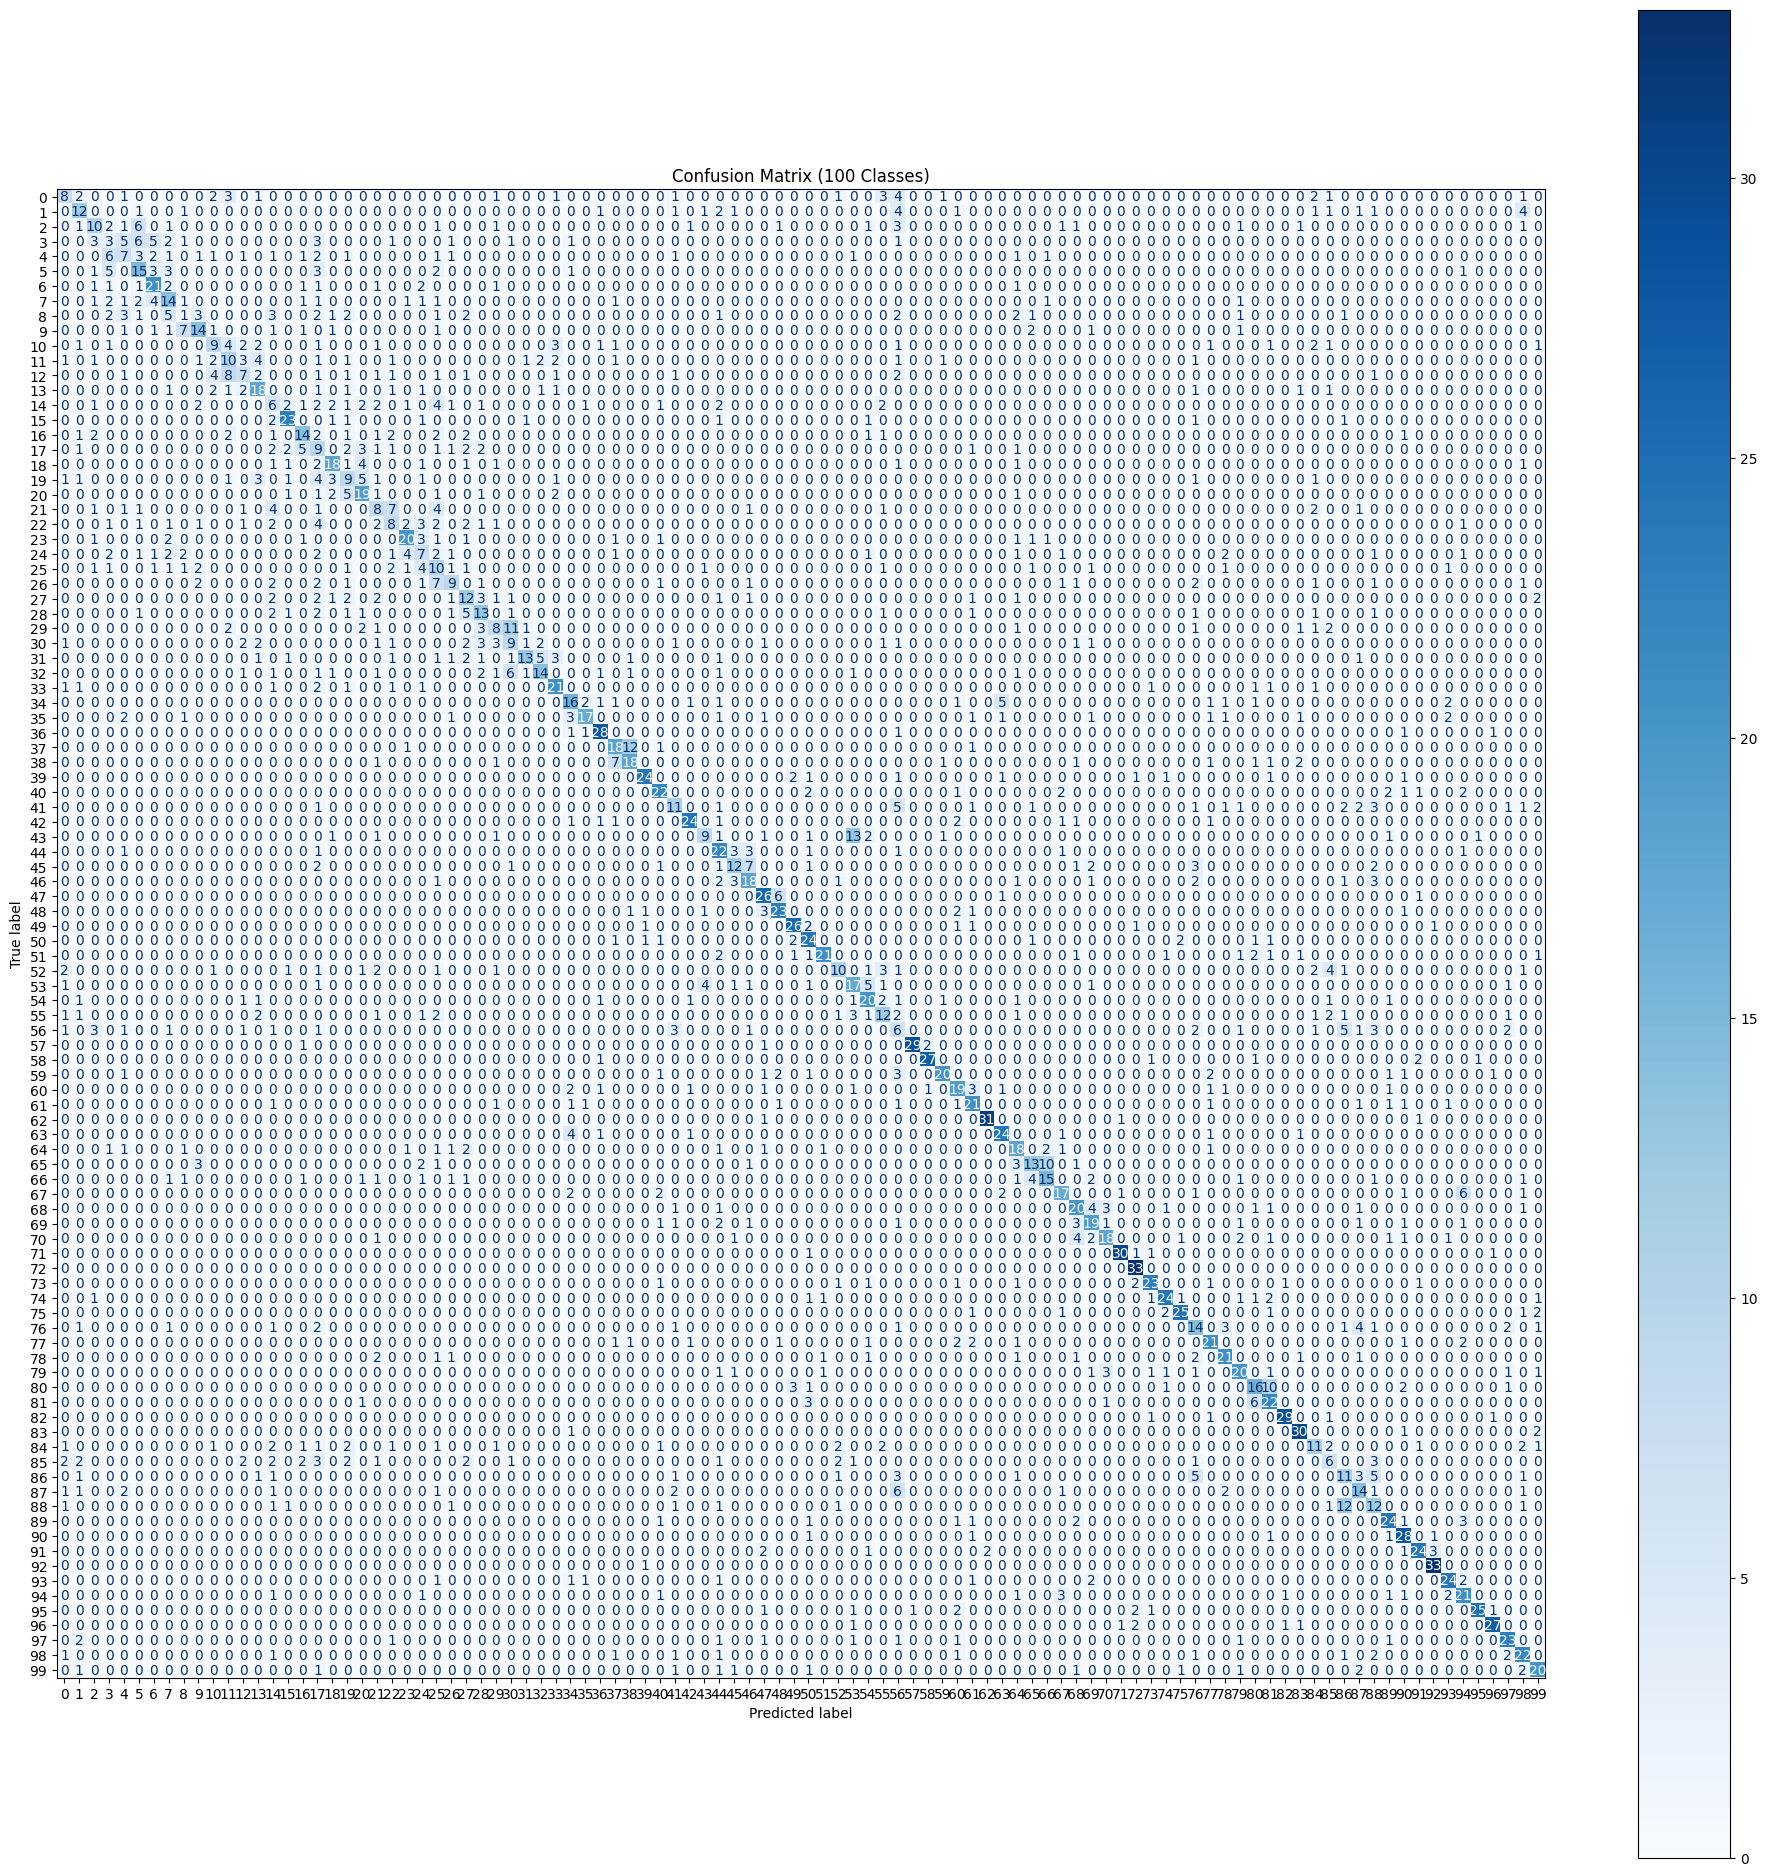

In [20]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Move to CPU and convert to list
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Generate and Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(24, 24))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d', ax=ax)
plt.title('Confusion Matrix (100 Classes)')
plt.show()

# Question 2 What did you learn? What is the difference between transfer learning and fine tuning? 

In transfer learning, we take a massive dataset and use it as a feature extractor. We freeze the entire backbone except for the final classifier layer. However in fine tuning, we don't freeze the entire backbone of the model, rather we adjust it accordingly to our task. In transfer learning, we normally use standard or high learning rate, whereas in fine tuning we use low learning rate. 

So from this assignment, I have learned the difference between transfer learning and fine tuning. I have learnt how to freeze or adjust the backbone and the reasoning behind doing this step. 